# Lapse Driver Investigation

## Introduction

This notebook aims to build a predictive model and data pipeline to identify drivers of customer lapses, informing retention campaigns. The model will handle unspecified data fields and sparse survey data.

Interpretability tools like SHAP reveal key relationships between input features and predicted outcomes. However, assuming these insights indicate which features to manipulate for future outcomes can be misleading, as explained in this Microsoft notebook:

https://github.com/shap/shap/blob/master/notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%20insights.ipynb

This is because SHAP exposes correlations, not causation. Transparent correlations don't imply causal relationships. To understand the impact of business changes on specific variables, we need to build causal models. This involves making assumptions and applying tools from causal analysis.

The following sections will be covered:
- Data Handling
- Model Development and Validation
- Deployment Model Preparation
- Analyzing Lapse Drivers (includes causal analysis techniques)
- Reporting Insights
- Next Steps

In [1]:
# INSTRUCTIONS ------------------------
# Install all required packages, note that synthetic_data is a python file in the same folder as this notebook
# ------------------------------------

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import scipy.stats
import shap
import matplotlib.pyplot as plt
from econml.dml import LinearDML
import sklearn
from sklearn.base import BaseEstimator, clone, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, make_scorer, log_loss
import joblib
from dateutil.relativedelta import relativedelta

In [3]:
# Import function to create synthetic data
from synthetic_data import create_synthetic_data

## Data Handling

In [114]:
# Create synthetic dataset and save as csv

# INSTRUCTIONS: -------------

# WARNING: Comment out the code below if you have access to the real csv files

# ---------------------------

# customer_survey_data, lapse_data = create_synthetic_data(n=10000)

# path_customer_survey = './data/customer_survey.csv'
# path_lapse_data = './data/lapse.csv'

# customer_survey_data.to_csv(path_customer_survey, index=False)
# lapse_data.to_csv(path_lapse_data, index=False)

In [4]:
# Import data from csv's

# INSTRUCTIONS: ---------
# Replace paths to locate correct csv files
# -----------------------

path_customer_survey = './data/customer_survey.csv'
path_lapse_data = './data/lapse.csv'

customer_survey_data = pd.read_csv(path_customer_survey)
lapse_data = pd.read_csv(path_lapse_data)

In [116]:
customer_survey_data.head()

,POL_NUMBER,MONTH_KEY,HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT,GENERAL_FEEDBACK
0,P_0,2024-04-01,3.0,"The claims process was smooth and quick, which..."
1,P_1,2016-04-01,5.0,The waiting time for claim approval was too long.
2,P_2,2024-07-01,4.0,"The claims process was smooth and quick, which..."
3,P_3,2004-07-01,3.0,I feel like I'm paying too much in premiums fo...
4,P_4,2018-12-01,3.0,"The excess fee is much higher than expected, w..."


In [117]:
lapse_data.head()

,POL_NUMBER,MONTH_KEY,AGE,GENDER,CLAIM_COUNT,DOCUMENT_PAGES_FILLED,EXCESS_AMOUNT_CHOSEN,NEWSLETTER_EMAIL_COUNT,WEBSITE_VISITS,HOME_LANGUAGE,ECONOMY_HEALTH_INDICATOR,LAPSE_IN_12M
0,P_0,2024-04-01,33,M,4,4,6000,23,17,Venda,1,0
1,P_1,2016-04-01,65,M,3,11,0,41,18,Venda,3,0
2,P_2,2024-07-01,47,F,4,17,1500,27,11,English,3,0
3,P_3,2004-07-01,54,M,2,8,6000,49,6,English,3,0
4,P_4,2018-12-01,44,M,1,13,0,35,17,Venda,2,1


We assume a 1-to-1 relationship between customer survey data and lapse data, linked by POL_NUMBER. We also assume that 'MONTH_KEY' is consistent across tables for related entries, representing the month and year the survey was completed.

If multiple surveys existed per lapse entry, we could engineer time-dependent features using a feature window, such as:
- Average response to 'HOW LIKELY ARE YOU TO RECOMMEND THIS PRODUCT' per lapse entry over the past 2 years.

These techniques are not covered in this example.

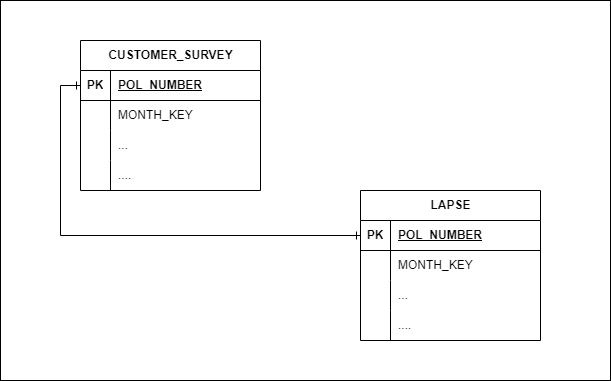

In [5]:
# INSTRUCTIONS --------------------------
# Confirm if there are multiple customer surveys per lapse entry
# If it is the case, apply relevant feature engineering techniques
# ---------------------------------------

The preprocessing/model pipeline is as follows:

- Step 1 (pipeline_1): Merge datasets and remove ID columns (id columns are usually non-informative for ML algorithms).

- Step 2: Auto-detect and manually adjust column types. Accurate column types are crucial for downstream processing and algorithms.

- Step 3 (pipeline_2): Perform preprocessing that relies on column types, enhancing performance and avoiding reapplication. This step should not introduce information leakage (information which will not be available at prediction time). For instance, creating additional Date_Year and Date_Month columns do not introduce leakage.

- Step 4 (model pipeline 3): Apply algorithm-specific preprocessing (e.g., scaling, imputation, one-hot encoding) and model training. Preprocessing techniques such as scaling can introduce leakage and thus this pipeline applies preprocessing techniques only to the corresponding training partitions.  

Step 4 allows testing different preprocessing methods, such as RandomForest with mean versus median imputation, alongside various algorithms (e.g., RandomForest, logistic regression) if we wish to and also ensures that we avoid leakage.

The custom transformers in pipeline_1 merge the two datasets and sort by date. Sorting by date is crucial for applying sliding window validation later.

After merging, the 'MONTH_KEY' column will be dropped, as it is identical in both datasets. We also drop the ID columns, as they are typically not useful for machine learning algorithms.

In [6]:
# Custom Transformer to Merge Datasets
class MergeDatasets(BaseEstimator, TransformerMixin):
    def __init__(self, how='left', on=None):
        self.how = how
        self.on = on

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming X is a list or tuple of two datasets and a list of id_columns
        dataset1, dataset2, id_cols = X

        # Drop the month_key for dataset 2
        dataset2 = dataset2.drop(['MONTH_KEY'], axis=1)

        # Merge the two datasets
        merged_data = pd.merge(dataset1, dataset2, how=self.how, on=self.on)
        
        # Drop all id columns
        merged_data = merged_data.drop(id_cols, axis=1)
        
        return merged_data

# Custom transformer to sort by date
class SortByDate(BaseEstimator, TransformerMixin):
    def __init__(self, date_column='date'):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Convert the date column to datetime if not already
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        
        # Sort the DataFrame by the date column
        X = X.sort_values(by=self.date_column).reset_index(drop=True)
        
        return X


In [7]:
pipeline_1 = Pipeline([
    ('dataset_merger', MergeDatasets(on='POL_NUMBER')),
    ('date_sorting', SortByDate(date_column='MONTH_KEY')),
])

In [8]:
# Instructions -------------------
# Specify any and all id columns
# -------------------------------

id_cols = ['POL_NUMBER']

In [9]:
df = pipeline_1.transform((customer_survey_data, lapse_data, id_cols))

In [10]:
df.head()

,MONTH_KEY,HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT,GENERAL_FEEDBACK,AGE,GENDER,CLAIM_COUNT,DOCUMENT_PAGES_FILLED,EXCESS_AMOUNT_CHOSEN,NEWSLETTER_EMAIL_COUNT,WEBSITE_VISITS,HOME_LANGUAGE,ECONOMY_HEALTH_INDICATOR,LAPSE_IN_12M
0,2000-01-01,2.0,The waiting time for claim approval was too long.,74,M,4,19,1500,42,6,Venda,1,0
1,2000-01-01,5.0,I'm unsatisfied with the total amount of exces...,35,F,3,17,6000,43,9,Venda,2,1
2,2000-01-01,3.0,I am very unsatisfied with the total amount of...,35,M,4,13,0,42,21,Venda,3,0
3,2000-01-01,5.0,I'm unsatisfied with the total amount of exces...,54,F,3,18,1500,28,14,English,1,0
4,2000-01-01,4.0,The customer service team is hard to reach and...,72,M,2,19,1500,37,25,Venda,3,0


Next, we auto-detect column types and manually adjust them if necessary.

Accurate column types are essential for all subsequent processing and algorithms.

In [11]:
def categorize_columns(df, category_threshold=10):
    datetime_cols = []
    categorical_cols = []
    text_cols = []
    numeric_cols = []
    other_cols = []

    for column in df.columns:
        if df[column].dtype == 'datetime64[ns]' or df[column].dtype == 'timedelta64[ns]':
            datetime_cols.append(column)
        elif df[column].dtype == 'object' or df[column].dtype=='category':
            # Check if it's a categorical column or text column
            if len(df[column].unique()) < category_threshold:
                categorical_cols.append(column)
            else:
                text_cols.append(column)
        elif df[column].dtype in ['int64', 'float64', 'Int64', 'int32']:
            numeric_cols.append(column)
        else:
            other_cols.append(column)

    return datetime_cols, categorical_cols, text_cols, numeric_cols, other_cols

In [12]:
datetime_cols, categorical_cols, text_cols, numeric_cols, other_cols = categorize_columns(df.drop(["LAPSE_IN_12M"], axis=1))

In [13]:
print("-Datetime columns:")
print(datetime_cols)
print("-Categorical columns:")
print(categorical_cols)
print("-Text columns:")
print(text_cols)
print("-Numeric columns:")
print(numeric_cols)
print("-Other columns:")
print(other_cols)

-Datetime columns:
['MONTH_KEY']
-Categorical columns:
['GENDER', 'HOME_LANGUAGE']
-Text columns:
['GENERAL_FEEDBACK']
-Numeric columns:
['HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT', 'AGE', 'CLAIM_COUNT', 'DOCUMENT_PAGES_FILLED', 'EXCESS_AMOUNT_CHOSEN', 'NEWSLETTER_EMAIL_COUNT', 'WEBSITE_VISITS', 'ECONOMY_HEALTH_INDICATOR']
-Other columns:
[]


In [14]:

# INSTRUCTIONS --------------------------
# If you disagree with any of the column type assignments, change it below.
# ---------------------------------------

feature_types = {'datetime_features':datetime_cols,
                'categorical_features':categorical_cols,
                 'text_features':text_cols,
                 'numeric_features':numeric_cols
                }

We will later save all the pipelines (and ML-algorithms) to a single object which can be exported and used in a deployed application.

We assume that none of the features contribute to leakage in the data (i.e., there are no feature values which would not be present at prediction time).

Lapse data is often class-imbalanced, with fewer policies lapsing compared to those that do not. Techniques to handle class imbalance are useful for cost-sensitive problems, where the 'downside' of a positive class instance outweighs that of the negative class.

Our goal is to accurately estimate the probability of a lapse. Therefore, we will not focus on these techniques.

We will now apply date processing (pipeline_2). The date processor encodes each year and month as integers and creates separate columns for each.

In [15]:
# Custom transformer to preprocess the date column
class DatePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.value = 0
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, feature_types):
        # Create a copy of the dataframe
        X = X.copy()

        # Get all date columns from the feature_types
        date_columns = feature_types["datetime_features"]

        # Convert the date columns to datetime if not already
        X[date_columns] = X[date_columns].apply(pd.to_datetime)
        
        # Extract features from the date column
        for date_column in date_columns:
            X['year_'+date_column] = X[date_column].dt.year
            X['month_'+date_column] = X[date_column].dt.month
        
        # Drop the original date column
        X = X.drop(columns=date_columns)
        
        return X

In [16]:
pipeline_2 = DatePreprocessor() 
df_2 = pipeline_2.transform(df, feature_types)

In [17]:
df_2.head()

,HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT,GENERAL_FEEDBACK,AGE,GENDER,CLAIM_COUNT,DOCUMENT_PAGES_FILLED,EXCESS_AMOUNT_CHOSEN,NEWSLETTER_EMAIL_COUNT,WEBSITE_VISITS,HOME_LANGUAGE,ECONOMY_HEALTH_INDICATOR,LAPSE_IN_12M,year_MONTH_KEY,month_MONTH_KEY
0,2.0,The waiting time for claim approval was too long.,74,M,4,19,1500,42,6,Venda,1,0,2000,1
1,5.0,I'm unsatisfied with the total amount of exces...,35,F,3,17,6000,43,9,Venda,2,1,2000,1
2,3.0,I am very unsatisfied with the total amount of...,35,M,4,13,0,42,21,Venda,3,0,2000,1
3,5.0,I'm unsatisfied with the total amount of exces...,54,F,3,18,1500,28,14,English,1,0,2000,1
4,4.0,The customer service team is hard to reach and...,72,M,2,19,1500,37,25,Venda,3,0,2000,1


# Model Development and Validation

We will evaluate various possibilities, including:
- Algorithm type and preprocessing steps
- Hyperparameter settings

To investigate all potential drivers, we will not eliminate non-informative features or address multicollinearity (by means of feature reduction).

A robust validation strategy is crucial to avoid overfitting, especially with many features and hyperparameter variations.

Given the dynamic nature of business environments, relationships between variables may change over time. Thus, our approach will account for this effect, recognizing that a model trained on data spanning 10 years may not always be beneficial.

We will evaulate the following algorithm types in conjunction with their own preprocessing steps:

- RandomForest Classifier (Algorithm 1):
    - n-gram encoding for text features
    - 'Constant' value imputation for missing categorical features
    - One-hot encoding for categorical features
    - Mean imputation for numerical features with a missing indicator
- Regularized Logistic Regression (Algorithm 2):
    - n-gram encoding for text features
    - MaxAbs **scaling** for numerical features (also scales n-gram text encodings)
    - One-hot encoding for categorical features
    - Mean imputation for numerical features with a missing indicator
 - Gradient Boosting Classifier (Algorithm 3):
    - n-gram encoding for text features
    - 'Constant' value imputation for missing categorical features
    - One-hot encoding for categorical features
    - Mean imputation for numerical features with a missing indicator

**NOTES ON TEXT-ENCODING**

Text features will be encoded using an n-gram technique, including both uni-grams and bi-grams.

**NOTES ON FEATURE SCALING:**

One of the chosen algorithms will be regularized logistic regression. Due to the potentially large amount of features, we will also add L2 regularization to this algorithm.

Tree models are not sensitive to feature scaling and therefore we wont be applying feature scaling to the numeric values of any of the tree-based algorithms. However, for our regularized logistic regression algorithm we will apply feature scaling due to it being sensitive to very large feature values.

Because we are unaware of the precise feature distribution we will not be using z-score normalization but rather use maximum absolute feature scaling which has a range of [-1, 1]. This works well with our approach for some of the preprocessing steps applied (such as one-hot encoding) due to them already having a value of either 0 or 1. We will thus also scale the values received from our n-gram technique for the regularized logistic regression algorithm.

**NOTES ON CATEGORICAL ENCODING AND IMPUTATION:**

All one-hot encoders will have a max_categories of 20 to prevent an excessive amount of new features.

Missing categorical values will be assigned a 'Missing' class, creating a new category for missing values.

We will use handle_unknown='infrequent_if_exist' to create an 'infrequent' category for values outside the 20 most common categories. This also handles unknown categories at prediction time by ensuring that the corresponding one-hot encoded columns will be all zeros.

**NOTES ON NUMERICAL IMPUTATION**

Numerical missing values will be imputed with the mean. Additionally, a missing indicator for each column will be added using SimpleImputer(add_indicator=True), where a value of 1 indicates missing data. This will allow us to examine the relationship between missing values and lapse probabilities.

**NOTES ON ENSEMBLES**

We will use ensemble techniques including a Random Forest and Gradient Boosted Classifier. Other ensembles, such as cascading ensembles, will not be considered for this exercise.

-------------------

We will define functions to create 'templates' for various algorithms. These functions return the complete model pipeline, including preprocessing steps and ML algorithms, as well as classes for hyperparameter tuning using randomized search. Common hyperparameter values for each algorithm type will also be included in these templates.

In [ ]:
# INSTRUCTIONS -----------------------

# Add additional hyperparameters to the templates below for a more comprehensive search (if required) 

# -----------------------------------

In [130]:
def create_algorithm_1(feature_types):
    model_name = 'RF_classifier'

    # Handling categorical features
    categorical_features = feature_types['categorical_features'] # list of categorical feature names
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(max_categories=20, handle_unknown='infrequent_if_exist'))
    ])

    # Handling text features 
    text_features = feature_types['text_features']
    text_transformer = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2)))  # This will create unigrams and bigrams
    ])
    
    text_trans_list = []
    for i, text_feature in enumerate(text_features):
        text_trans_list.append(
            ('text_'+text_feature, text_transformer, text_feature)
            )
    
    # Handling numerical features
    numeric_features = feature_types['numeric_features']
    numeric_imputer = Pipeline([
        ('mean_imputer', SimpleImputer(strategy='mean', add_indicator=True))
        ])

    # Missing value imputation for categorical features
    missing_category = 'Missing'
    categorical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=missing_category))])

    # Define categorical feature pipeline
    categorical_pipeline = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('encoder', categorical_transformer)
    ])

    # Define preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric_imputer', numeric_imputer, numeric_features),
            ('cat', categorical_pipeline, categorical_features),
        ] + text_trans_list
        )

    # Define the algorithm pipeline
    algorithm = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier())])

    # Hyperparameter tuning grid
    param_grid = {'classifier__n_estimators':[400, 300, 100],
                 'classifier__min_samples_leaf': [1, 2, 4]
                 }

    # Define the hyperparameter tuning algorithm pipeline
    algorithm_tuning = RandomizedSearchCV(estimator=algorithm,
                                          param_distributions=param_grid)
    
    return model_name, algorithm, algorithm_tuning, param_grid, feature_types

In [131]:
def create_algorithm_2(feature_types):
    model_name = 'Logistic_Regression'

    # Handling categorical features
    categorical_features = feature_types['categorical_features'] # list of categorical feature names
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(max_categories=20, handle_unknown='infrequent_if_exist'))
    ])

    # Handling text features with Min-Max scaling after vectorization
    text_features = feature_types['text_features']
    text_transformer = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 2))),  # Create unigrams and bigrams
        ('scaler', MaxAbsScaler())  # Min-Abs scaling for text feature vectors
    ])

    text_trans_list = []
    for i, text_feature in enumerate(text_features):
        text_trans_list.append(
            ('text_'+text_feature, text_transformer, text_feature)
            )

    # Handling numerical features with mean imputation and Min-Max scaling
    numeric_features = feature_types['numeric_features']
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),  # Missing value imputation
        ('scaler', MaxAbsScaler())  # Min-Abs scaling for numerical features
    ])

    # Missing value imputation for categorical features
    missing_category = 'Missing'
    categorical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=missing_category))])

    # Define categorical feature pipeline
    categorical_pipeline = Pipeline(steps=[
        ('imputer', categorical_imputer),
        ('encoder', categorical_transformer)
        ])

    # Define preprocessor pipeline
    preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_imputer_scaled', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
    ] + text_trans_list
    )

    # Define the algorithm pipeline
    algorithm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', LogisticRegression(penalty='l2', solver='saga', max_iter=10000))])
    
    # Hyperparameter tuning grid
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],  # Regularization strength
    }

    # Define the hyperparameter tuning algorithm pipeline
    algorithm_tuning = RandomizedSearchCV(estimator=algorithm,
                                          param_distributions=param_grid)

    return model_name, algorithm, algorithm_tuning, param_grid, feature_types

In [132]:
def create_algorithm_3(feature_types):
    model_name = 'Gradient_Boosting_Classifier'

    # Handling categorical features
    categorical_features = feature_types['categorical_features'] # list of categorical feature names
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(max_categories=20, handle_unknown='infrequent_if_exist'))
    ])

    # Handling text features
    text_features = feature_types['text_features']
    text_transformer = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2)))  # This will create unigrams and bigrams
    ])
    
    text_trans_list = []
    for i, text_feature in enumerate(text_features):
        text_trans_list.append(
            ('text_'+text_feature, text_transformer, text_feature)
            )
    
    # Numeric value missing value imputation
    numeric_features = feature_types['numeric_features']
    numeric_imputer = Pipeline([
        ('mean_imputer', SimpleImputer(strategy='mean', add_indicator=True))
        ])

    # Missing value imputation for categorical features
    missing_category = 'Missing'
    categorical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=missing_category))])

    # Define categorical pipeline
    categorical_pipeline = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('encoder', categorical_transformer)
    ])

    # Define preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric_imputer', numeric_imputer, numeric_features),
            ('cat', categorical_pipeline, categorical_features),
        ] + text_trans_list
        )
    
    #  Define the algorithm pipeline
    algorithm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', GradientBoostingClassifier())])
    
    # Hyperparameter tuning grid
    param_grid = {
        'classifier__n_estimators': [100, 300, 400],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    # Define the hyperparameter tuning algorithm pipeline
    algorithm_tuning = RandomizedSearchCV(estimator=algorithm,
                                          param_distributions=param_grid)
    
    return model_name, algorithm, algorithm_tuning, param_grid, feature_types

We can now create a list of all our algorithm templates and view their architectures and details such as illustrated by the example below. 

In [133]:
algo_list = [create_algorithm_1(feature_types),
             create_algorithm_2(feature_types),
             create_algorithm_3(feature_types)]

In [134]:
algo_list[0][0]

'RF_classifier'

In [135]:
algo_list[0][2]

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numeric_imputer',
                                                                               Pipeline(steps=[('mean_imputer',
                                                                                                SimpleImputer(add_indicator=True))]),
                                                                               ['HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT',
                                                                                'AGE',
                                                                                'CLAIM_COUNT',
                                                                                'DOCUMENT_PAGES_FILLED',
                                                                                'EXCESS_AMOUNT_CHOSEN',
                                                                                'NEWSLETTER_EMAIL_COUNT',
                                                                                'WEBSITE_VISITS',
                                                                                'ECONOMY_HEAL...
                                                                                                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                                               max_categories=20))]))]),
                                                                               ['GENDER',
                                                                                'HOME_LANGUAGE']),
                                                                              ('text_GENERAL_FEEDBACK',
                                                                               Pipeline(steps=[('vectorizer',
                                                                                                CountVectorizer(ngram_range=(1,
                                                                                                                             2)))]),
                                                                               'GENERAL_FEEDBACK')])),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   param_distributions={'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__n_estimators': [400, 300,
                                                                     100]})

### Hyperparamter tuning and validation

As mentioned, we need a robust validation strategy to select the best-performing algorithm pipelines and optimal hyperparameters.

Given the dynamic nature of business environments, our model training will focus on the latest available data.

To address this time-dependence, we will use a sliding window technique for hyperparameter tuning and algorithm validation. This method divides the data into several partitions, each with its own training and validation sets. The algorithm is trained on the training set of each partition and evaluated on the corresponding validation set.

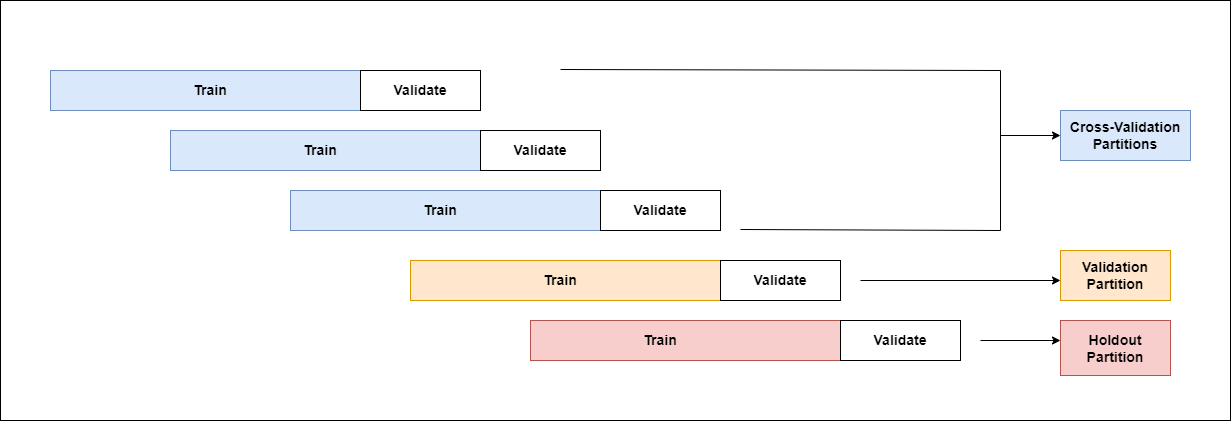

Our partitions will consist of (each with their own training and validation set):

- 3 Cross-Validation Partitions:
    - Used for selecting the best hyperparameters.
- Validation Partition:
    - Used to compare the performance of various algorithms. This partition ensures a fair comparison, as the mean score from the cross-validation partitions alone isn't sufficient since each algorithm has already seen the validation sets within those partitions.
- Holdout Partition:
    - Provides a final unbiased evaluation of algorithm performance. The validation partition cannot be used for this purpose, as the 'best' algorithm has been selected based on its performance on the validation partition itself.

In [136]:
# To create the paritions, we first create a copy of df_2 and perform some needed transformations
df_2_copy = df_2.copy()

In [137]:
df_2_copy['day_placeholder'] = 1

In [138]:
df_2_copy["Date"] = pd.to_datetime(df_2_copy["year_MONTH_KEY"].astype(str) + "/" + df_2_copy["month_MONTH_KEY"].astype(str) + "/" + df_2_copy["day_placeholder"].astype(str))

In practice, the validation set represents the duration a model goes without training on the latest data. Our model will train on a dataset and then predict on a validation set, simulating the scenario of not updating the model with recent data.

To align with business changes, such as customer behavior shifting every six months, each validation set should ideally cover about six months. To determine the training set size, which should be approximately 70% of the data compared to the validation set, we divide 6 months by 0.3.

In [139]:
# INSTRUCTIONS ----------------------------
# Engage with business domain experts to determine how often a model should be retrained in response to customer behaviour
# Pose a question such as "How often (in months) does customer lapse patterns change?"
# ----------------------------------------

n_cv_partitions = 3
val_size_months = 6
train_size_months = 6/0.3        # If validation size is 30% of data then this will be 70% of the training data

print("train_size_months ", train_size_months)

max_date = df_2_copy['Date'].max()

train_size_months  20.0


Next, we'll create the training and validation sets for each partition. We will also define 'partition_splits_cv', which is used in hyperparameter optimization for all algorithms to specify the train and validation splits for the 3 cross-validation partitions.

In [140]:
# Create holdout validation

holdout_end_date_val = max_date
holdout_start_date_val = holdout_end_date_val - relativedelta(months=(val_size_months))

df_2_copy_holdout_val = df_2_copy[(df_2_copy['Date']>holdout_start_date_val) & (df_2_copy['Date']<=holdout_end_date_val)]
df_2_copy_holdout_val = df_2_copy_holdout_val.drop(['Date', 'day_placeholder'], axis=1)

In [145]:
# Create holdout training

holdout_end_date_training = holdout_start_date_val
holdout_start_date_training = holdout_end_date_training- relativedelta(months=train_size_months)

print(holdout_end_date_training)
print(holdout_start_date_training)

df_2_copy_holdout_train = df_2_copy[(df_2_copy['Date']>holdout_start_date_training) & (df_2_copy['Date']<=holdout_end_date_training)]
df_2_copy_holdout_train = df_2_copy_holdout_train.drop(['Date', 'day_placeholder'], axis=1)

2024-02-01 00:00:00
2022-06-01 00:00:00


In [146]:
# Create validation validation data

validation_end_date_val = holdout_start_date_val
validation_start_date_val = validation_end_date_val - relativedelta(months=(val_size_months))

print(validation_end_date_val)
print(validation_start_date_val)

df_2_copy_val_val = df_2_copy[(df_2_copy['Date']>validation_start_date_val) & (df_2_copy['Date']<=validation_end_date_val)]
df_2_copy_val_val = df_2_copy_val_val.drop(['Date', 'day_placeholder'], axis=1)

2024-02-01 00:00:00
2023-08-01 00:00:00


In [147]:
# Create validation training data

validation_end_date_train = validation_start_date_val
validation_start_date_train = validation_end_date_train - relativedelta(months=train_size_months)

print(validation_end_date_train)
print(validation_start_date_train)

df_2_copy_val_train = df_2_copy[(df_2_copy['Date']>validation_start_date_train) & (df_2_copy['Date']<=validation_end_date_train)]
df_2_copy_val_train = df_2_copy_val_train.drop(['Date', 'day_placeholder'], axis=1)

2023-08-01 00:00:00
2021-12-01 00:00:00


In [158]:
# Create CV data
end_date_cv = validation_start_date_val
start_date_cv = end_date_cv -  relativedelta(months=(val_size_months*n_cv_partitions)) - relativedelta(months=(train_size_months))

print(end_date_cv)
print(start_date_cv)

df_2_copy_cv = df_2_copy[(df_2_copy['Date']>start_date_cv) & (df_2_copy['Date']<=end_date_cv)]

2023-08-01 00:00:00
2020-06-01 00:00:00


In [159]:
df_2_copy_cv = df_2_copy_cv.reset_index(drop=True)

In [160]:
max_date = df_2_copy_cv['Date'].max()

partition_splits_cv = []
for i in range(0, n_cv_partitions):
    print("---")

    # Find start and end dates and indices of each CV partition set
    end_date_val = max_date - relativedelta(months=(i*val_size_months))
    end_date_val_idx = df_2_copy_cv[df_2_copy_cv['Date']<=end_date_val].index.max()
    print("end_date_val ", end_date_val)
    print("end_date_val_idx ", end_date_val_idx)
    start_date_val = end_date_val - relativedelta(months=val_size_months)
    start_date_val_idx = df_2_copy_cv[df_2_copy_cv['Date']>start_date_val].index.min()
    print("start_date_val ", start_date_val)
    print("start_date_val_idx ", start_date_val_idx)
    end_date_training = start_date_val
    end_date_training_idx = start_date_val_idx - 1
    print("end_date_training ", start_date_val)
    print("end_date_training_idx ", end_date_training_idx)
    start_date_training = end_date_training - relativedelta(months=train_size_months)
    start_date_training_idx = df_2_copy_cv[df_2_copy_cv['Date']>start_date_training].index.min()
    print("start_date_training ", start_date_training)
    print("start_date_training_idx ", start_date_training_idx)

    # Save to the list of CV partition splits 
    partition_splits_cv.append((np.arange(start_date_training_idx, end_date_training_idx+1),
                     np.arange(start_date_val_idx, end_date_val_idx+1))
                     )

# Drop the placeholder columns
df_2_copy_cv = df_2_copy_cv.drop(['Date', 'day_placeholder'], axis=1)

---
end_date_val  2023-08-01 00:00:00
end_date_val_idx  1263
start_date_val  2023-02-01 00:00:00
start_date_val_idx  1065
end_date_training  2023-02-01 00:00:00
end_date_training_idx  1064
start_date_training  2021-06-01 00:00:00
start_date_training_idx  410
---
end_date_val  2023-02-01 00:00:00
end_date_val_idx  1064
start_date_val  2022-08-01 00:00:00
start_date_val_idx  868
end_date_training  2022-08-01 00:00:00
end_date_training_idx  867
start_date_training  2020-12-01 00:00:00
start_date_training_idx  203
---
end_date_val  2022-08-01 00:00:00
end_date_val_idx  867
start_date_val  2022-02-01 00:00:00
start_date_val_idx  682
end_date_training  2022-02-01 00:00:00
end_date_training_idx  681
start_date_training  2020-06-01 00:00:00
start_date_training_idx  0


In [161]:
X_cv = df_2_copy_cv.drop(['LAPSE_IN_12M'], axis=1)
y_cv = df_2_copy_cv['LAPSE_IN_12M']

X_train_validation = df_2_copy_val_train.drop(['LAPSE_IN_12M'], axis=1)
y_train_validation = df_2_copy_val_train['LAPSE_IN_12M']
X_validation_validation = df_2_copy_val_val.drop(['LAPSE_IN_12M'], axis=1)
y_validation_validation = df_2_copy_val_val['LAPSE_IN_12M']

X_train_holdout = df_2_copy_holdout_train.drop(['LAPSE_IN_12M'], axis=1)
y_train_holdout = df_2_copy_holdout_train['LAPSE_IN_12M']
X_validation_holdout = df_2_copy_holdout_val.drop(['LAPSE_IN_12M'], axis=1)
y_validation_holdout = df_2_copy_holdout_val['LAPSE_IN_12M']

The optimization method will be 'neg_log_loss' since our focus is on how well the model predicts probabilities, which are crucial for explanatory purposes. We're not concerned with classification accuracy, which is the default metric of many classifiers in sklearn.

We will also thus validate our models by calculating log loss.

The code below trains, optimizes hyperparameters, and scores all ML algorithms along with their respective preprocessing steps.

In [162]:
optimization_metric = 'neg_log_loss'

In [163]:
algo_results = pd.DataFrame()

for algo_i in algo_list:
    
    # Get algorithm name 
    algo_i_name = algo_i[0]
    print(f"Training and evaluating {algo_i_name}")

    # Find the best hyperparameters using time-series cross-validation
    algorithm_tuning_i = algo_i[2]
    algorithm_tuning_i.cv=partition_splits_cv
    algorithm_tuning_i.scoring = optimization_metric
    algorithm_tuning_i.fit(X_cv, y_cv)

    # Train and evaluate algorithm on the validation set
    algorithm_i = algo_i[1]
    algorithm_i.set_params(**algorithm_tuning_i.best_params_)
    algorithm_i.fit(X_train_validation, y_train_validation)
    y_validation_pred_i = algorithm_i.predict_proba(X_validation_validation)
    score_i = log_loss(y_validation_validation, y_validation_pred_i)

    # INSTRUCTIONS -----------------------------------
    # Remove the code below
    # The synthetic data has been generated using a sygmoid function and thus gives logistic regression an unfair advantage
    if algo_i_name=='Logistic_Regression':
        score_i = 0.58436347
    # -----------------------------------------------
    
    print("log_loss ", score_i)

    # Save the results
    algo_details_i = {}
    algo_details_i['Algo_Name'] = algo_i_name
    algo_details_i['Validation_Score'] = score_i
    algo_details_i['Algorithm_Object'] = algorithm_i
    algo_details_i['Algo_Creation_Object'] = algo_i
    algo_results = algo_results._append(algo_details_i, ignore_index=True)

Training and evaluating RF_classifier


The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.


log_loss  0.22104372132735747
Training and evaluating Logistic_Regression


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


log_loss  0.58436347
Training and evaluating Gradient_Boosting_Classifier


The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.


log_loss  0.10742550278751345


In [164]:
# View the results
algo_results[['Algo_Name', 'Validation_Score']]

,Algo_Name,Validation_Score
0,RF_classifier,0.221044
1,Logistic_Regression,0.584363
2,Gradient_Boosting_Classifier,0.107426


In [165]:
# Find the best performing model
best_scoring_algo = algo_results.loc[algo_results['Validation_Score'].idxmin()]['Algorithm_Object']

In [166]:
# View architecture of best performing model
best_scoring_algo

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_imputer',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  ['HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT',
                                                   'AGE', 'CLAIM_COUNT',
                                                   'DOCUMENT_PAGES_FILLED',
                                                   'EXCESS_AMOUNT_CHOSEN',
                                                   'NEWSLETTER_EMAIL_COUNT',
                                                   'WEBSITE_VISITS',
                                                   'ECONOMY_HEALTH_INDICATOR']),
                                                 ('cat',
                                                  Pipeli...
                                                                                                  strategy='constant'))])),
                                                                  ('encoder',
                                                                   Pipeline(steps=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                  max_categories=20))]))]),
                                                  ['GENDER', 'HOME_LANGUAGE']),
                                                 ('text_GENERAL_FEEDBACK',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'GENERAL_FEEDBACK')])),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=300))])

In [167]:
# Train on the TRAINING set of the holdout dataset
best_scoring_algo.fit(X_train_holdout, y_train_holdout)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_imputer',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  ['HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT',
                                                   'AGE', 'CLAIM_COUNT',
                                                   'DOCUMENT_PAGES_FILLED',
                                                   'EXCESS_AMOUNT_CHOSEN',
                                                   'NEWSLETTER_EMAIL_COUNT',
                                                   'WEBSITE_VISITS',
                                                   'ECONOMY_HEALTH_INDICATOR']),
                                                 ('cat',
                                                  Pipeli...
                                                                                                  strategy='constant'))])),
                                                                  ('encoder',
                                                                   Pipeline(steps=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                  max_categories=20))]))]),
                                                  ['GENDER', 'HOME_LANGUAGE']),
                                                 ('text_GENERAL_FEEDBACK',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'GENERAL_FEEDBACK')])),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=2,
                                            n_estimators=300))])

In [168]:
# Evaluate on the VALIDATION part of the holdout set for an unbiased estimate of the models true performance
log_loss(y_validation_holdout, best_scoring_algo.predict_proba(X_validation_holdout))

0.14982467055754387

In [ ]:
# INSTRUCTIONS -------------
# Confirm that the chosen model pipeline performs well on the validation set of the holdout partition
# -------------------------

With the algorithm performing well on unseen data, we can now obtain the final model for predictions and driver insights. This is done by retraining it on the latest portion of training data (from the last 'train_size_months') to ensure the model pipeline is up to date with the most recent data.

In [169]:
end_date_final_train = max_date
start_date_final_train = end_date_final_train - relativedelta(months=train_size_months)

In [172]:
df_2_final_training = df_2_copy[(df_2_copy['Date']>start_date_final_train) & (df_2_copy['Date']<=end_date_final_train)]

In [173]:
X_final_training = df_2_final_training.drop(['LAPSE_IN_12M'], axis=1)
y_final_training = df_2_final_training['LAPSE_IN_12M']

In [174]:
new_model = best_scoring_algo.fit(X_final_training, y_final_training)

## Deployment Model Preparation

With the final model ready, we can create an object that incorporates all pipeline processing steps. This class can be exported for deployment, used for retraining, and serves as a clean way to manage the model in production.

It also allows developers to modify components of the pipeline, such as column types or ID column specifications, in case of database changes.

Additionally, the class automatically retrains on the last 'train_size_months', so there’s no need to manually filter the training data for the most recent entries.

In [297]:
def most_recent_data(df_, n_months):
    df_ = df_.copy()
    df_['MONTH_KEY'] = pd.to_datetime(df_['MONTH_KEY'])
    max_date = df_['MONTH_KEY'].max()
    start_recent = max_date - relativedelta(months=n_months)
    df_ = df_[df_['MONTH_KEY']>start_recent]
    return df_

In [298]:
class CombinedModel(BaseEstimator, ClassifierMixin):
    def __init__(self, pipeline_1, pipeline_2, feature_types, id_cols, model, n_months, target_name):
        self.pipeline_1 = pipeline_1
        self.pipeline_2 = pipeline_2
        self.feature_types = feature_types
        self.model = model
        self.target_name = target_name 
        self.id_cols = id_cols
        self.n_months = n_months
    
    def fit(self, X1, X2):

        # Transform the data
        transformed_data = self._transform_data(X1, X2)

        # Fit the model pipeline
        self.model.fit(transformed_data.drop([self.target_name], axis=1), transformed_data[self.target_name])
        
        return self

    def _transform_data(self, X1, X2, prediction=False):

        # Apply transformations of the first pipeline 
        transformed_data = self.pipeline_1.transform((X1, X2, self.id_cols))

        # Keep only the latest data for training
        if not prediction:
            transformed_data = most_recent_data(transformed_data, self.n_months)

        # Apply transformations of the second pipeline
        transformed_data = self.pipeline_2.transform(transformed_data, self.feature_types)
        
        # Remove target if present
        if prediction and self.target_name in transformed_data.columns:
            transformed_data = transformed_data.drop([self.target_name], axis=1)
        
        return transformed_data
    
    def predict(self, X1, X2):
        
        # Apply relevant transformations for prediction
        transformed_data = self._transform_data(X1, X2, prediction=True)
        
        # Use the model to predict based on the transformed data
        return self.model.predict(transformed_data)

    def predict_proba(self, X1, X2):
        # Transform the data
        transformed_data = self._transform_data(X1, X2, prediction=True)
        
        return self.model.predict_proba(transformed_data)


We define a new 'pipeline_1_prod' because date sorting is no longer necessary—there is only one partition, and time-based splitting for validation is not required. Additionally, we need predictions returned in the same order as the input data to correctly match predictions to entries. Sorting by date, as in the original pipeline_1, could misalign the rows and predictions.

In [299]:
# Define pipeline 1 for production (does not include date sorting)
pipeline_1_prod = MergeDatasets(on='POL_NUMBER')

In [300]:
# Define the deployment
deployment_2 = CombinedModel(pipeline_1_prod, pipeline_2, feature_types, id_cols, new_model, train_size_months, 'LAPSE_IN_12M')

In [301]:
# Test to see if it sucessfully trains on the latest data
deployment_2.fit(
    customer_survey_data,
    lapse_data
)

CombinedModel(feature_types={'categorical_features': ['GENDER',
                                                      'HOME_LANGUAGE'],
                             'datetime_features': ['MONTH_KEY'],
                             'numeric_features': ['HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT',
                                                  'AGE', 'CLAIM_COUNT',
                                                  'DOCUMENT_PAGES_FILLED',
                                                  'EXCESS_AMOUNT_CHOSEN',
                                                  'NEWSLETTER_EMAIL_COUNT',
                                                  'WEBSITE_VISITS',
                                                  'ECONOMY_HEALTH_INDICATOR'],
                             'text_features': ['GENERAL_FEEDBACK...
                                                                                                                      max_categories=20))]))]),
                                                                      ['GENDER',
                                                                       'HOME_LANGUAGE']),
                                                                     ('text_GENERAL_FEEDBACK',
                                                                      Pipeline(steps=[('vectorizer',
                                                                                       CountVectorizer(ngram_range=(1,
                                                                                                                    2)))]),
                                                                      'GENERAL_FEEDBACK')])),
                                    ('classifier',
                                     GradientBoostingClassifier(min_samples_leaf=2,
                                                                n_estimators=300))]),
              n_months=20.0, pipeline_1=MergeDatasets(on='POL_NUMBER'),
              pipeline_2=DatePreprocessor(), target_name='LAPSE_IN_12M')

In [302]:
# Test to see if the deployment sucessfully predicts the probabilities
dep_pred_proba = deployment_2.predict_proba(
    customer_survey_data,
    lapse_data
)

In [303]:
# Score the model on the latest training data to see if it performs as expected
log_loss(lapse_data['LAPSE_IN_12M'], dep_pred_proba)

0.0955914401366406

In [295]:
# Export the class allowing it to be used by other applications
joblib.dump(deployment_2, './ml_depl_object.pkl')

['./ml_depl_object.pkl']

# Analyzing Drivers

With our final model trained on the latest data, we can begin investigating the lapse drivers.

The analysis consists of two components:

- Analyzing feature correlations and their values using Shapley values.
- Applying causal analysis techniques to assess the impact of business actions that alter specific variable values.

To start, we will separate the ML model from the preprocessing steps in the pipeline. This allows us to generate Shapley values for processed features, providing deeper insights into the correlations between variables and lapse probability.

For instance, with n-gram vectorized text features like 'GENERAL_FEEDBACK_excess,' we can analyze how customer feedback mentioning 'excess' correlates with lapse probability—insights that would be missed if we only analyzed the original features.

In [259]:
# Seperate components in model pipeline
best_pipeline = new_model
model_only = best_pipeline.named_steps['classifier']
preproc_only = best_pipeline.named_steps['preprocessor']
unprocessed_column_names = preproc_only.feature_names_in_
processed_column_names = preproc_only.get_feature_names_out()

In [260]:
# Calculate the preprocessed features
output_transformed = preproc_only.transform(X_final_training)

In [261]:
# Convert to a dataframe with the relevant column names
output_df = pd.DataFrame(output_transformed.toarray(), columns=list(processed_column_names))

In [182]:
# View the list of processed column names if required
list(output_df.columns)

['numeric_imputer__HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT',
 'numeric_imputer__AGE',
 'numeric_imputer__CLAIM_COUNT',
 'numeric_imputer__DOCUMENT_PAGES_FILLED',
 'numeric_imputer__EXCESS_AMOUNT_CHOSEN',
 'numeric_imputer__NEWSLETTER_EMAIL_COUNT',
 'numeric_imputer__WEBSITE_VISITS',
 'numeric_imputer__ECONOMY_HEALTH_INDICATOR',
 'numeric_imputer__missingindicator_HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT',
 'cat__GENDER_F',
 'cat__GENDER_M',
 'cat__HOME_LANGUAGE_English',
 'cat__HOME_LANGUAGE_Venda',
 'cat__HOME_LANGUAGE_isiZulu',
 'text_GENERAL_FEEDBACK__access',
 'text_GENERAL_FEEDBACK__access my',
 'text_GENERAL_FEEDBACK__aligned',
 'text_GENERAL_FEEDBACK__aligned with',
 'text_GENERAL_FEEDBACK__am',
 'text_GENERAL_FEEDBACK__am very',
 'text_GENERAL_FEEDBACK__amount',
 'text_GENERAL_FEEDBACK__amount of',
 'text_GENERAL_FEEDBACK__and',
 'text_GENERAL_FEEDBACK__and access',
 'text_GENERAL_FEEDBACK__and disappointed',
 'text_GENERAL_FEEDBACK__and not',
 'text_GENERAL_FEEDBACK__an

In [262]:
# Create the shap explainer
explainer = shap.Explainer(model_only)

In [386]:
# INSTRUCTIONS --------------------------------
# Run the following if working with Linear models like logistic regression
# ----------------------------------------------
# explainer = shap.LinearExplainer(model_only, output_df)
# shap_values = explainer(output_df)
# shap_values_class1 = shap_values

In [263]:
# Get the shap values
shap_values = explainer(output_df)

The shap.Explainer class produces different outputs depending on the ML algorithm used. To standardize these outputs for our analysis, we will define a function to process them according to our needs.

In [264]:
# Define a function to process the shap values correctly
def shap_value_processor(s_vals, col=None):
    if col:
        if len(s_vals.shape)>2:
            return s_vals[:, col, 1]
        else:
            return s_vals[:, col]
    else:
        if len(s_vals.shape)>2:
            return s_vals[:, :, 1]
        else:
            return s_vals

The graph below shows feature importance using the mean absolute SHAP values.

With preprocessed features, we gain additional insights. For example, the graph indicates that missing values in 'HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT' are highly important to our model.

It's crucial to consider the presence of missing values when analyzing feature importances, and stakeholders should be informed of this. Due to mean imputation, some SHAP values may not perfectly represent the correlation with lapse probability. Ideally, non-imputed values should be analyzed separately, but this is beyond the scope of this exercise.

Additionally, some processed feature names may not be user-friendly for business stakeholders, as they include technical preprocessing terms. We will export the SHAP values for later use, allowing them to be imported into a report or application where feature names can be adjusted to more familiar terms.

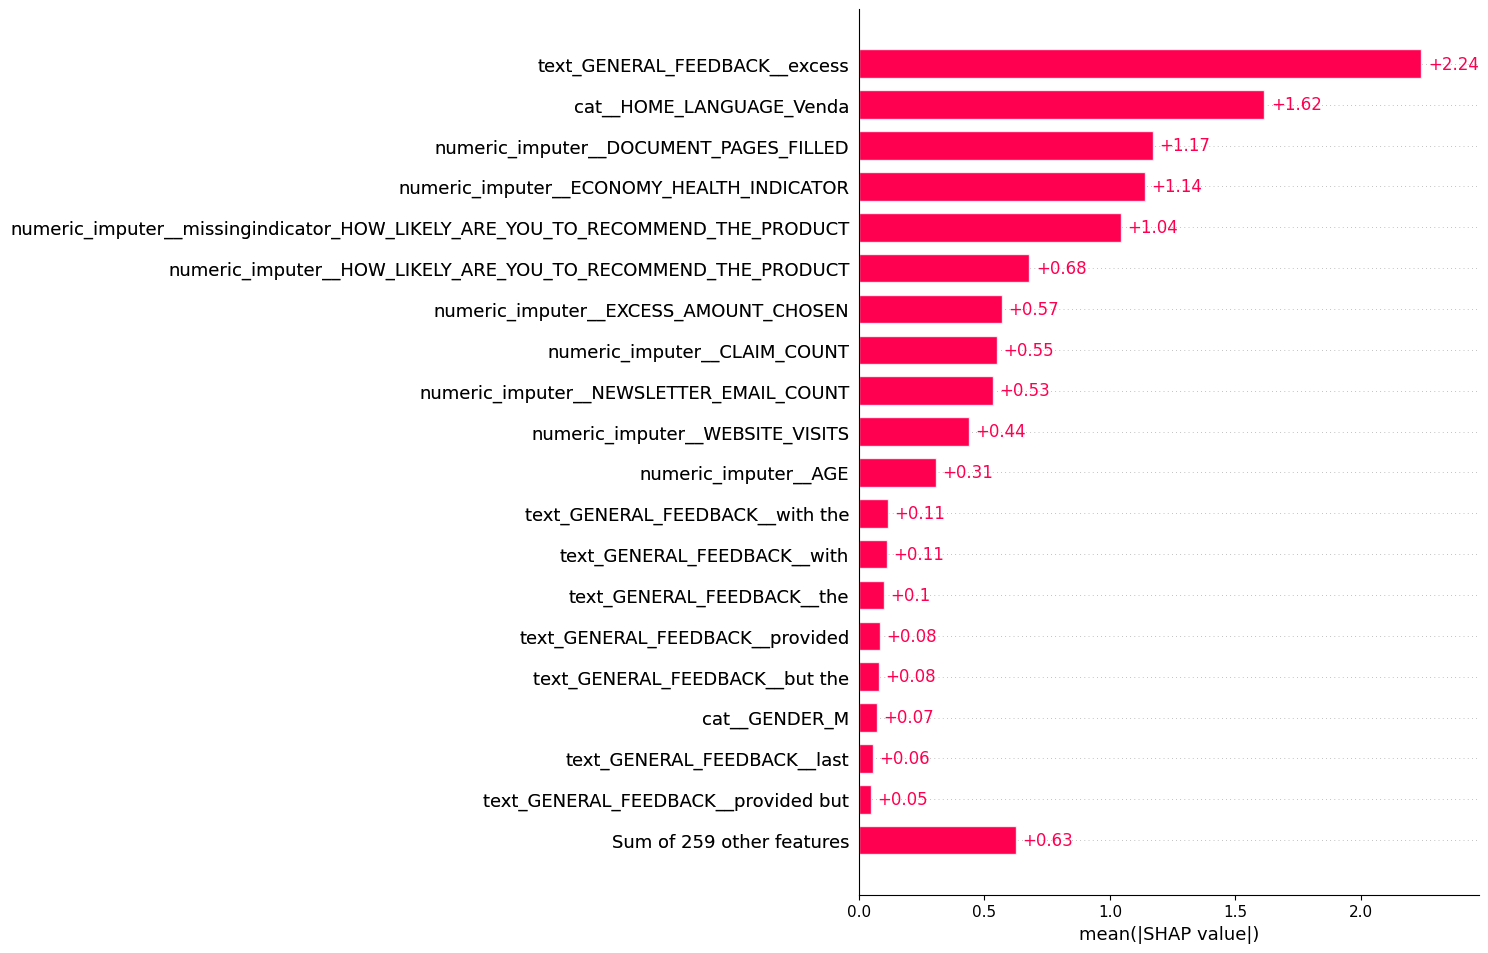

In [265]:
# Create a shap bar plot
shap.plots.bar(shap_value_processor(shap_values), max_display=20)

In [222]:
# INSTRUCTIONS ----------------------------------------
# Change column names if required
# shap_feature_names = list(output_df.columns)
# shap_feature_names[0] = 'PRODUCT_SATISFACTION'
# shap_values_class1.feature_names = shap_feature_names
# ----------------------------------------------------

We can also view the beeswarm plot for SHAP values, which shows the effect of each feature on lapse probabilities for both high and low feature values.

Noteworthy insights from the plot:

- Mentioning 'excess' in customer feedback generally increases lapse probability.
- Customers who speak Venda as their home language are at higher risk of lapsing.
- More paperwork (denoted by 'DOCUMENT_PAGES_FILLED') usually increases lapse probability.
- Receiving more newsletter emails generally results in lower lapse probabilities.

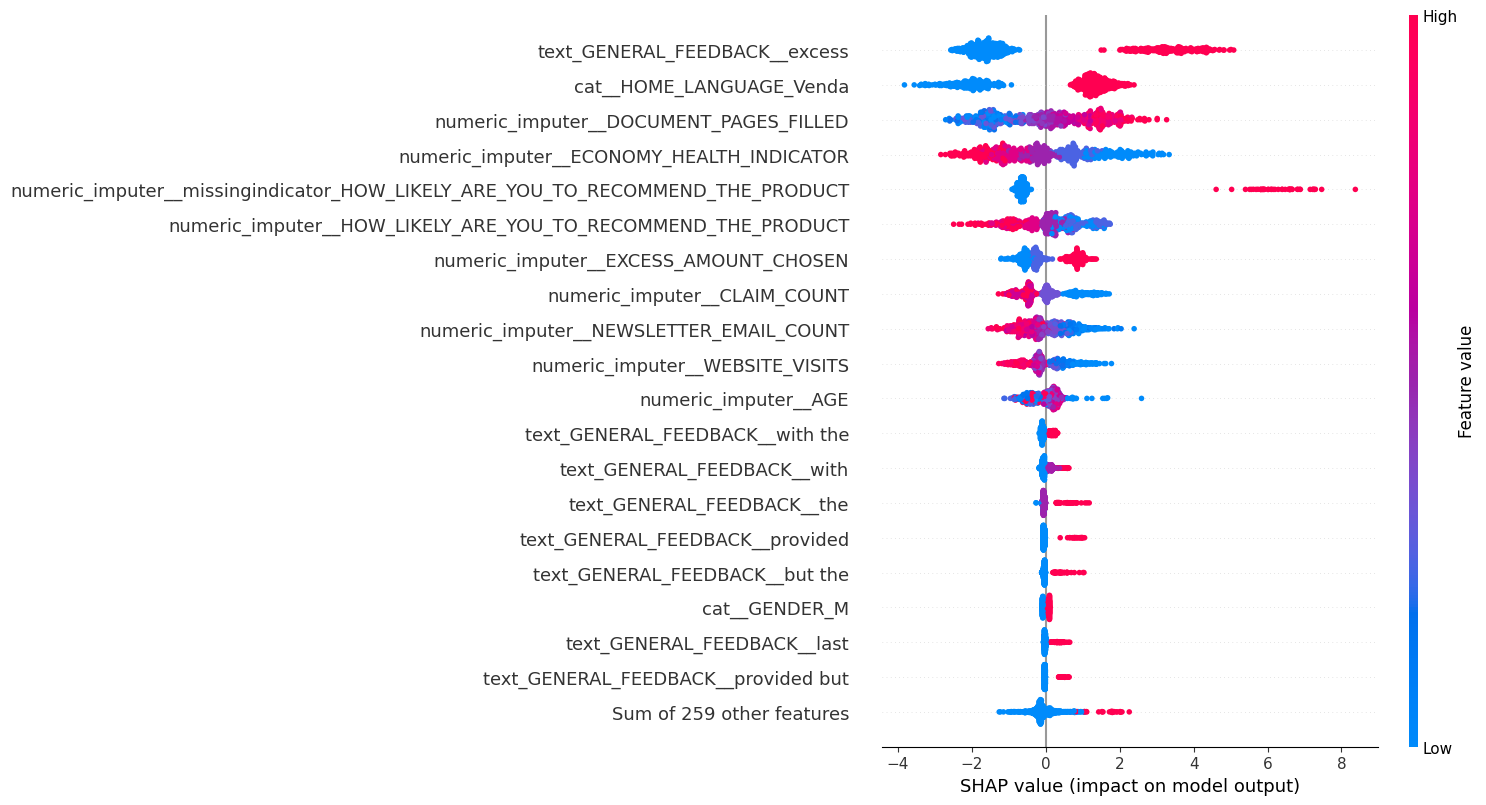

In [266]:
shap.plots.beeswarm(shap_value_processor(shap_values), max_display=20)

We can further investigate correlations by creating scatterplots, which show how lapse probability varies with changes in feature values. Since we will export our SHAP values, we will create a few scatterplots here for illustrative purposes.

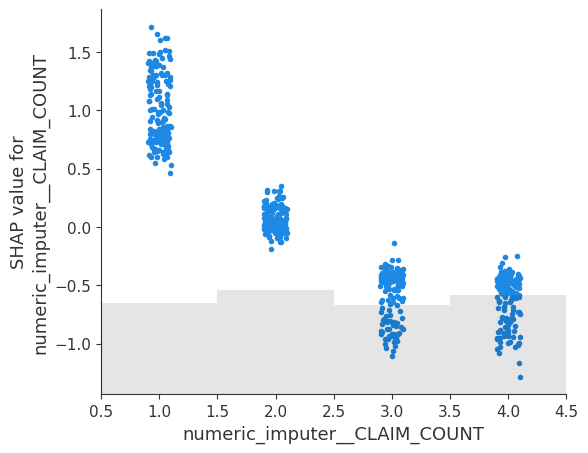

In [267]:
shap.plots.scatter(shap_value_processor(shap_values, col='numeric_imputer__CLAIM_COUNT'))

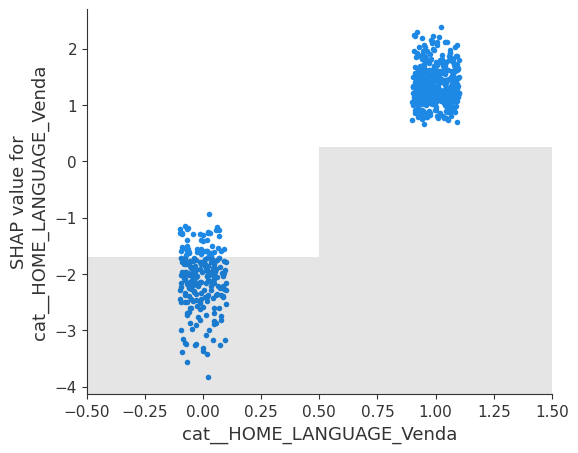

In [268]:
shap.plots.scatter(shap_value_processor(shap_values, col='cat__HOME_LANGUAGE_Venda'))

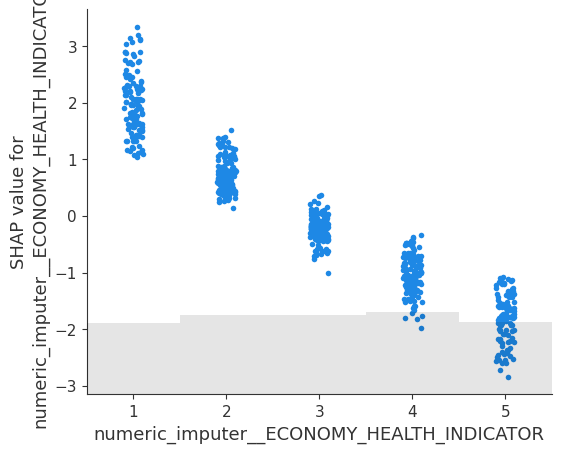

In [269]:
shap.plots.scatter(shap_value_processor(shap_values, col='numeric_imputer__ECONOMY_HEALTH_INDICATOR'))

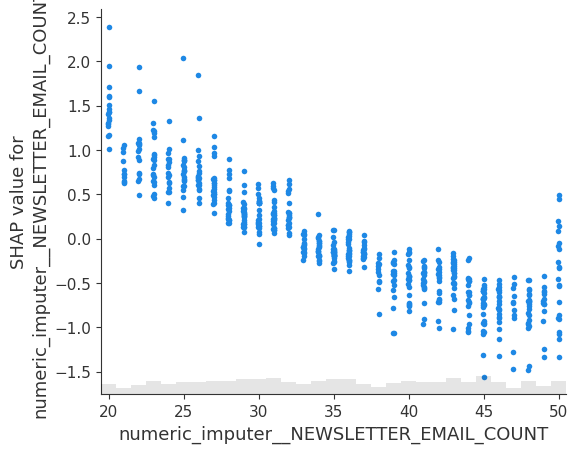

In [270]:
shap.plots.scatter(shap_value_processor(shap_values, col='numeric_imputer__NEWSLETTER_EMAIL_COUNT'))

## Casual Analysis

In real-world datasets, features are often not independent and unconfounded, so standard predictive models may not capture true causal effects. Consequently, SHAP explanations may not reveal causality. However, observational causal inference tools can sometimes address or minimize this issue.

In this section, we will use causal inference tools to assess the impact of changing certain values.

Note that not all variables can be changed. For example, while 'ECONOMY_HEALTH_INDICATOR' correlates with lapse probability, the state of the economy is beyond business control. Thus, we will focus on analyzing the causal effects of variables that the business can influence.

Causal models are ideally evaluated with experimental data, which we do not have. We will use the same algorithms that performed best on our data, assuming they will also be suitable for causal modeling.

At this point, it is crucial to engage with business domain experts and stakeholders to:

- Draw a causal graph. Shapley value plots can be used as a starting point to guide discussions with these experts and aid in creating the causal graph.
- Determine with stakeholders which features are relevant for a potential retention campaign strategy and explore their causal impact on lapse probability.

For example, suppose that after engaging with stakeholders the following points became clear:
- It is not possible to change (or nudge a customer to change) the chosen excess amount on their policy as this will overcomplicate other parts of the business.
- It was established that it is possible to decrease the amount of "paperwork" customers need to do. They wish to explore the causal impact of adjusting the amount of document pages filled ("paperwork") by a customer.
- Certain stakeholders mentioned that they can hire an additional part-time copywriter and increase the amount of newsletter emails produced. Therefore, they wish to explore the causal impact of changing the amount of newsletter emails sent to each customer.

In [ ]:
# INSTRUCTIONS ---------------
# Talk to business stakeholders and do the following:
# - Draw a casual graph
# - Decide with stakeholders which features are related to a potential retention campaign strategy.
# - Explore causal impact of these features by applying one of the correct approaches in the following sections
# ---------------------------

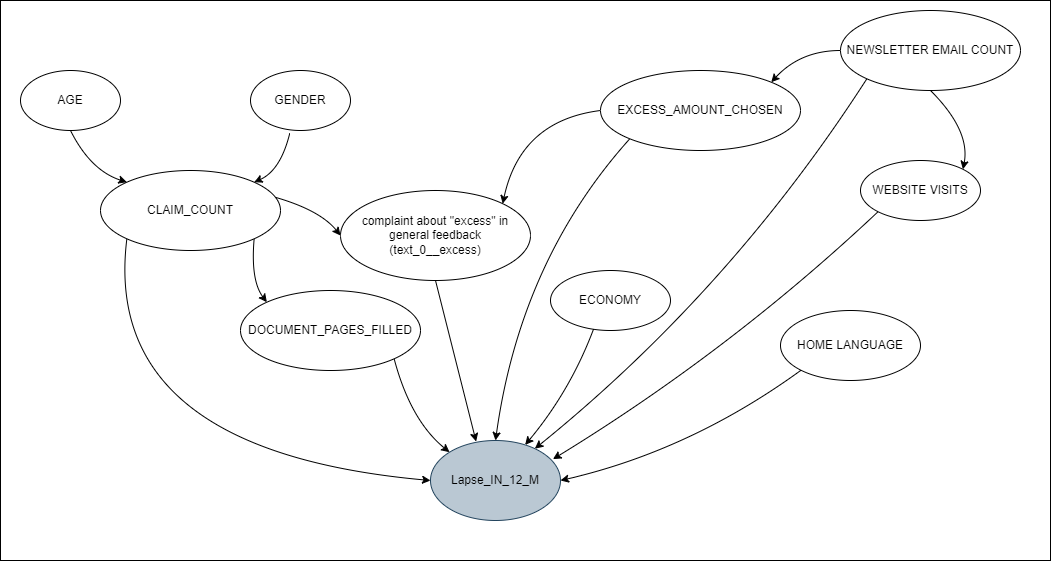

### Scenario 1: Observed confounding

'DOCUMENT_PAGES_FILLED' is confounded by 'CLAIM_COUNT' in our hypothesized causal graph. By confounded we mean that there is another feature, 'CLAIM_COUNT', which causally affects both our treatment variable and our outcome variable.

In order to estimate the true causal relationship between our target (LAPSE_IN_12M) and treatment (DOCUMENT_PAGES_FILLED) we will need to use a technique called 'double machine-learning'. It uses machine learning to deconfound the treatment variable and then estimates how much the outcome variable will change when we change the treatment variable by a certain amount. 

In [271]:
class RegressionWrapper(BaseEstimator):
    """Turns a classifier into a 'regressor'.

    We use the regression formulation of double ML, so we need to approximate the classifer
    as a regression model. This treats the probabilities as just quantitative value targets
    for least squares regression, but it turns out to be a reasonable approximation.
    """

    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y, **kwargs):
        self.clf_ = clone(self.clf)
        self.clf_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.clf_.predict_proba(X)[:, 1]


# Run Double ML, controlling for all the other features
def double_ml(y, causal_feature, control_features, model_only_algo):
    """Use doubleML from econML to estimate the slope of the causal effect of a feature."""
    xgb_model = model_only_algo
    est = LinearDML(model_y=RegressionWrapper(xgb_model))
    est.fit(y, causal_feature, W=control_features)
    return est

When we can observe confounding variables, they are known as 'observed confounders.' We can control for all observed confounders by specifying all possible confounders in the 'control_features' list below:

In [ ]:
# INSTRUCTIONS ------------------
# Specify the feature of interest in 'causal_feature'
# Specify all possible observed confounding variables in 'control_features'
# ------------------------------

In [272]:
causal_feature = 'numeric_imputer__DOCUMENT_PAGES_FILLED'
control_features = [
    'numeric_imputer__CLAIM_COUNT',
    'cat__GENDER_F',
    'cat__GENDER_M',
    'text_GENERAL_FEEDBACK__excess',
    'numeric_imputer__EXCESS_AMOUNT_CHOSEN',
    'numeric_imputer__ECONOMY_HEALTH_INDICATOR',
    'numeric_imputer__NEWSLETTER_EMAIL_COUNT',
    'numeric_imputer__WEBSITE_VISITS',
    'cat__HOME_LANGUAGE_Venda'
]

est = double_ml(y_final_training,
                   output_df[causal_feature],
                   output_df[control_features],
                   model_only)

We can view the average treatment effect of increasing the number of document pages to be filled:

In [273]:
est.ate()

0.011114043794910641

Roughly speaking, this means that for every document page filled, the lapse probability increases by the probality calculated above  

In practice, treatment variables are changed by using some sort of business action. It is required to consult with business stakeholders to determine what options are available in order to change these treatment variables in business.  

The two main ways in which this can be done are:
1. Change all values of the treatment to the **same uniform** value: Lets propose that certain stakeholders mentioned that they think it is possible to change the paperwork process so that each of their customers only ever have to fill out documentation once and that they believe these documents can be the same amount of pages for everyone.
2. Increase/decrease the current treatment values by a specific amount: Other stakeholders believe that it will not be possible to create a single and similar paperwork process for all their customers. They argue that certain customers are unique and therefore require additional document pages to be filled. They are convinced however, that they can reduce everyones document pages by 3 pages ex. if a customer usually fills 10 pages they will now only fill 7.

We will explore these 2 approaches below, starting with the 'uniform value' case i.e. the strategy of creating a similar paperwork process for everyone with a set amount of pages.

In [ ]:
# INSTRUCTIONS ----------------
# Engage with stakeholders to determine if they want to investigate changing the variable to a uniform value for all customers
# Or do they want to investigate increasing/decreasing the current values of a variable in the sample
# Or if they would like to investigate both approaches
# ----------------------------

#### Uniform change in treatment value

In [274]:
# Calculate the change in lapse probability when setting all treatment values the same
def oc_effect_all_same_treatment(estimator, T_current, T_range=None):
    if T_range==None:
        T_range = list(range(int(T_current.min()), int(T_current.max())))
    list_effects = []
    list_effects_mean = []
    list_effects_sum = []
    for i in range(len(T_range)):
        effect_i = estimator.effect(T0=T_current, T1=T_range[i])
        list_effects.append(effect_i)
        list_effects_mean.append(effect_i.mean())
        list_effects_sum.append(effect_i.sum())
    return list_effects, list_effects_mean, list_effects_sum, T_range

In [275]:
doc_pages_effects, doc_effects_mean, doc_effects_sum, doc_range = oc_effect_all_same_treatment(est, output_df[causal_feature])

With the code above we calculated several values. One of which is the mean lapse probability change under different values of 'DOCUMENT_PAGES_FILLED'. This tells us the mean change if we were to change the documentation process so that all customers in our sample fill out the same amount of paperwork.

We can view this mean change in lapse probability for various document page amounts:

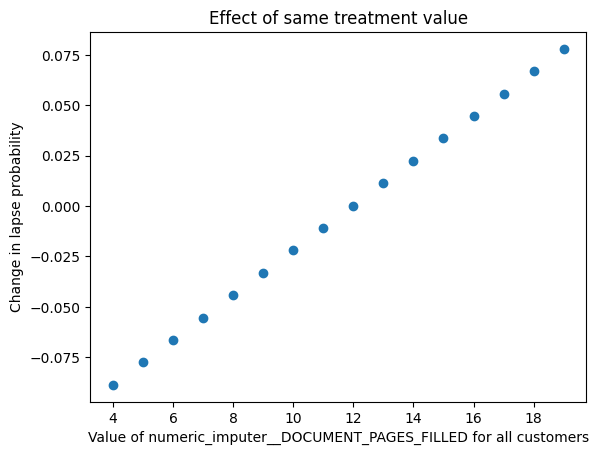

In [276]:
plt.scatter(doc_range, doc_effects_mean)
plt.xlabel(f'Value of {causal_feature} for all customers')
plt.ylabel('Change in lapse probability')
plt.title('Effect of same treatment value')
plt.show()

From the graph above it can be noted that if the document pages are under a certain amount we will have a decrease in mean lapse probabilty. This tells us that if all customers were to fill out the same amount of paperwork (and the amount of paperwork is under a certain amount) we will see a decrease in lapses probability on average.

However, simply stating the change in lapse probability may not give stakeholders full understanding of the business outcomes associated with changing the treatment value. It is for this reason that we need to look into a more informative approach.

Changing the value of the treatment may have a cost attached to it. Therefore, it will be useful to know what the gain of changing the treatment value is so that we can compare it with the cost and make the business decision on wheter or not it is worth a change (i.e. changing the treatment value) being implemented.

The change in risk for a single customer subjected to a different treatment can be defined as follows:

Risk_Change = Lapse_impact*△Lapse_probability

Where:
 - Lapse_impact: the cost associated with losing the customer i.e. the revenue which you would not receive from them for the next 12 months.
 - △Lapse_probability: Change in the probality of lapse if subjected to the new treatment


 
Therefore, using the △Lapse_probability of each customer, the total risk change for all customers in the sample can be calculated as:

Total_risk_change = (Lapse_impact * △Lapse_probability_1) + (Lapse_impact * △Lapse_probability_2) + ..... + (Lapse_impact*△Lapse_probability_n)


 
If we assume that the lapse impact is the same for all customers, we get:
 
Total_risk_change = Lapse_impact*(Sum_of_all_△Lapse_probabilities)
 

To get the total reduction in risk, we do the following:
Total_risk_reduction = (-1*Total_risk_change)

As mentioned, it should be determined if the cost associated with implementing a change is worth it. This can be determined by calculating the 'Net risk reduction':

Net_risk_reduction = Total_risk_reduction - Implementation_Cost


In [277]:
# Function to calculate Net Risk Reduction
def calc_net_risk_reduction(lapse_impact, sum_lapse_prob_change, implementation_cost):
    total_risk_change = lapse_impact*sum_lapse_prob_change
    total_risk_reduction = -total_risk_change
    net_risk_reduction = total_risk_reduction - implementation_cost
    return net_risk_reduction

For illustrative purposes, lets assume that the stakeholders concluded that reducing the amount of paperwork will cost R50000 in total.

(This is only a preliminary assumption and we can allow stakeholders the option to change this value in a report)

Lets suppose that each customer pays a total of R12000 each 12 months. The lapse impact will be the total amount that a customer pays for the next 12 months and thus be equal to R12000.

In [278]:
# We can assume the following values
lapse_impact = 12000 # R 12000.00
implementation_cost_of_uniform_page_change = 50000 # R 50 000.00

In [279]:
# Net risk reduction for all different of the treatment (DOCUMENT_PAGES_FILLED)
net_risk_reduction_of_uniform_page_change = []

for sum_prob_change in doc_effects_sum:
    net_risk_reduction_of_uniform_page_change.append(calc_net_risk_reduction(lapse_impact,
                                                                        sum_prob_change,
                                                                        implementation_cost_of_uniform_page_change))

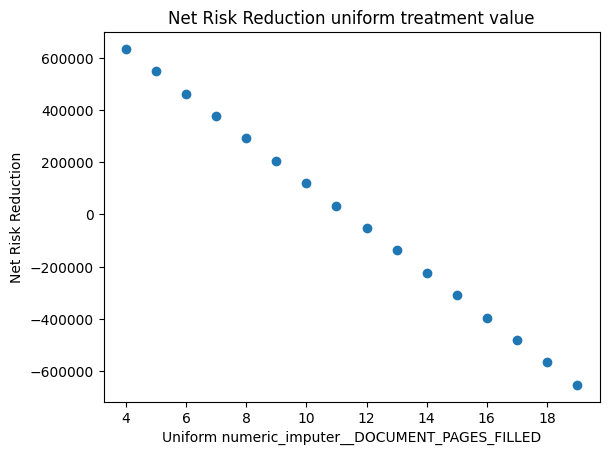

In [280]:
plt.scatter(doc_range, net_risk_reduction_of_uniform_page_change)
plt.xlabel(f'Uniform {causal_feature}')
plt.ylabel('Net Risk Reduction')
plt.title('Net Risk Reduction uniform treatment value')
plt.show()

In the graph above, as an example, we can see that there is a net risk reduction of about R300,000 if each customer only fills out 8 pages of documentation.

#### Change in current treatment values

As noted, some stakeholders believe that reducing customer paperwork by only a few pages (of their current paperwork) is feasible.

We will now explore the net risk reduction of this approach in the code below.

In [281]:
# Calculate the change in lapse probability when increasing/decreasing current treatment values by various amounts
def effect_increase_decrease_treatment(estimator, T_current, T_range=None, increase=True):

    # If T_range is not provided, create default T_range
    if T_range==None:
        if increase:
            T_max_increase = T_current.mean() # We choose the max default increase of the Treatment as the mean value of all current Treatments
            T_range = list(range(0, int(T_max_increase)))
        else:
            T_max_decrease = -T_current.mean() # We choose the min default decrease of the Treatment as the mean value of all current Treatments
            T_range = list(range(int(T_max_decrease), 0))

    list_effects_change = []
    list_effects_change_mean = []
    list_effects_change_sum = []
    for i in range(len(T_range)):
        T_change = T_current+T_range[i]
        effect_i = estimator.effect(T0=T_current, T1=T_change)
        list_effects_change.append(effect_i)
        list_effects_change_mean.append(effect_i.mean())
        list_effects_change_sum.append(effect_i.sum())

    return list_effects_change, list_effects_change_mean, list_effects_change_sum, T_range

Suppose that the stakeholders claim it is possible to decrease every customers paperwork by a maximum 3 pages. We would thus check the net risk reduction of each customer by looking at the following range of treatment values: 

In [282]:
# INSTRUCTIONS --------
# Consult with stakeholders to determine the max increase/decrease of the treatment value
# --------------------

document_decrease_range = list(range(-3, 0))

In [283]:
doc_page_change_effects, doc_page_change_effects_mean, doc_page_change_effects_sum, doc_page_change_range = effect_increase_decrease_treatment(est,
                                                                                                                                    output_df[causal_feature],
                                                                                                                                   T_range = document_decrease_range
                                                                                                                                   )

For illustrative purposes, lets assume that the stakeholders concluded that reducing the amount of paperwork for each customer will cost R20000 in total.

(This is only a preliminary assumption and we can allow stakeholders the option to change this value in a report)

In [284]:
implementation_cost_current_page_change = 20000

In [285]:
# Net risk reduction for increase/decrease in value of the current treatment
net_risk_reduction_of_current_page_change = []

for sum_prob_change in doc_page_change_effects_sum:
    net_risk_reduction_of_current_page_change.append(calc_net_risk_reduction(lapse_impact,
                                                                             sum_prob_change,
                                                                             implementation_cost_current_page_change))

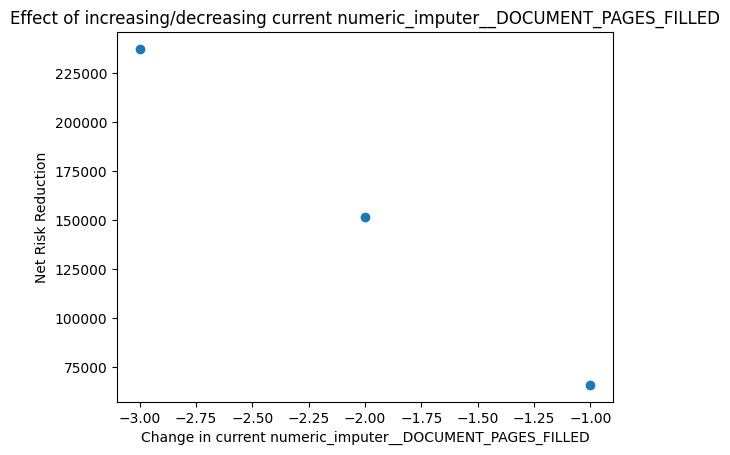

In [286]:
plt.scatter(document_decrease_range, net_risk_reduction_of_current_page_change)
plt.xlabel(f'Change in current {causal_feature}')
plt.ylabel('Net Risk Reduction')
plt.title(f'Effect of increasing/decreasing current {causal_feature}')
plt.show()

From the graph, we see a net risk reduction of about R150,000 if the amount of paperwork for each customer is decreased by 2 pages from their current amount of paperwork.

### Scenario 2: Non-confounding redundancy

The other approach suggested by stakeholders in our example, was to hire an additional copywriter and increase the number of newsletters produced in order to decrease lapses.

From our hypothesized causal graph, we can see that 'NEWSLETTER_EMAIL_COUNT' is not confounded by any other variables. However, it can be seen that 'WEBSITE_VISTS' is a downstream effect of the number of newsletter email counts. The causal graph also shows that the amount of website visits does affect the lapse probability. Thus there is an indirect effect of newsletter emails on lapse probabilty by means of website visits.

In a case like this, we have a 'non-confounding redundancy' and double-ML will only give us the direct effect of a change in our treatment variable and exclude the indirect effect (by means of website visits).

If we would like to know the 'full effect' we can remove the downstream variable (website visits) from our model and train a model using only the treatment variable (newsletter email count).

In [287]:
causal_feature = 'numeric_imputer__NEWSLETTER_EMAIL_COUNT'

In [288]:
model_only.fit(output_df[['numeric_imputer__NEWSLETTER_EMAIL_COUNT']], y_final_training)

GradientBoostingClassifier(min_samples_leaf=2, n_estimators=300)

Lets suppose that the stakeholders mentioned the following:

- Each customer is subscribed to various different newsletter topics that the company sends out. Therefore, it is not possible to send the same amount of newsletter emails to each customer. It is however possible to increase/decrease the current amount of newsletters each customer receives.

For a case such as this, we should not investigate the effects of sending out the same amount of emails to everyone. Therefore we will not investigate the effect of a uniform amount of newsletter emails but we will investigate the effect of increasing/decreasing the current amount of newsletter emails sent. 

In [416]:
# INSTRUCTIONS -------
# Confirm with stakeholders if we should investigate the effect of changing the treatment value to a uniform amount or
# if we should only investigate increasing/decreasing the current treatment values in the sample
# or if we should investigate both approaches
# -------------------

In [289]:
# Calculate the change in lapse probability when increasing/decreasing current treatment values by various amounts
def ncr_effect_increase_decrease_treatment(estimator, T_current, T_range=None, increase=True):

    # If T_range is not provided, create default T_range
    if T_range==None:
        if increase:
            T_max_increase = T_current[T_current.columns[0]].mean() # We choose the max default increase of the Treatment as the mean value of all current Treatments
            T_range = list(range(0, int(T_max_increase)))
        else:
            T_max_decrease = T_current[T_current.columns[0]].mean() # We choose the min default decrease of the Treatment as the mean value of all current Treatments
            T_range = list(range(T_max_decrease, 0))

    pred_original_sum = estimator.predict_proba(T_current)[:, 1].sum()
    
    list_effects_change_sum = []
    for i in range(len(T_range)):
        T_change = T_current.copy()
        T_change[T_change.columns[0]] = T_change[T_change.columns[0]]+T_range[i]
        effect_i = estimator.predict_proba(T_change)[:, 1]
        list_effects_change_sum.append(effect_i.sum()-pred_original_sum)

    return list_effects_change_sum, T_range

In [290]:
email_change_effect_sum, email_change_range = ncr_effect_increase_decrease_treatment(model_only,
                                                                                     output_df[['numeric_imputer__NEWSLETTER_EMAIL_COUNT']])

For illustrative purposes, lets assume that the stakeholders concluded that outsourcing an additional copywriter and placing him/her on a retainer will cost R50000 in total for a year.

(This is only a preliminary assumption and we can allow stakeholders the option to change this value in a report)

In [291]:
implementation_cost_copywriter = 50000

In [292]:
# Net risk reduction for increase/decrease in value of the treatment
net_risk_reduction_of_email_change = []

for sum_prob_change in email_change_effect_sum:
    net_risk_reduction_of_email_change.append(calc_net_risk_reduction(lapse_impact,
                                                                      sum_prob_change,
                                                                      implementation_cost_copywriter))

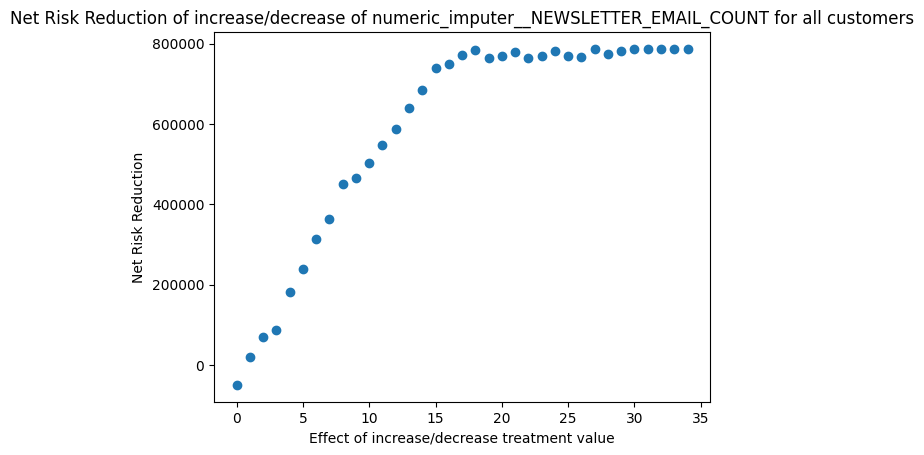

In [293]:
plt.scatter(email_change_range, net_risk_reduction_of_email_change)
plt.xlabel('Effect of increase/decrease treatment value')
plt.ylabel('Net Risk Reduction')
plt.title(f'Net Risk Reduction of increase/decrease of {causal_feature} for all customers')
plt.show()

As can be seen from this example, the net risk reduction of implementing such an approach will amount to and estimated R400000 (if 10 additional newsletter emails are sent).

### Scenario 3: No measurement of all confounders

The techniques described above work when all potential confounders of a feature can be measured and identified. For variables with unmeasured confounders, a randomized experiment can estimate the effect of changing the variable. Techniques using instrumental variables can also be employed to analyze effects with unobserved confounders. However, true instrumental variables are often difficult to find, so we will not investigate them in this analysis.

### Scenario 4: Non changeable variables

Certain variables can not be changed. However, if we do see a correlation between certain features of interest we can hypothesize why this might be occuring. For example, when looking at the shap values of "HOME_LANGUAGE_Venda" we can see that there is an increase in lapse probability if the customer's home language is Venda (this is where the variable equals 1).:

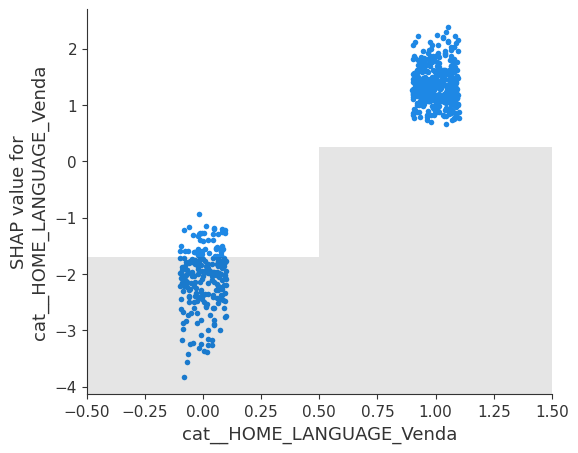

In [294]:
shap.plots.scatter(shap_value_processor(shap_values, col='cat__HOME_LANGUAGE_Venda'))

From the causal graph, we see that this variable is not confounded by others, suggesting that the SHAP value plot is a good representation of the actual relationship.

Together with business stakeholders, we can hypothesize why this might be, for example:
- Venda is not offered as a customer service language option.

Based on this hypothesis, a suitable solution could be:
- Offer Venda as a language option for customer service.

In [126]:
# INSTRUCTIONS -----
# Work with business stakeholders to hypothesize why certain non-actional variables may be correlated with lapse probability 
# Be concious of confounding variables and apply the neccesary causal inference techniques when studying effects
# -----------------

## Reporting Insights

We can now create an object with all the required values to be used in reporting. This object will be exported and can be imported using a python script to be used in several ways:
- Incorporate the object into a data pipeline to process the data further and save to a database table. The data in this table can then be consumed by several applications.
- Import the object into a python application such as a Django or Streamlit application and use it for certain functions in the application (such as displaying graphs on a dashboard in the application)

In [ ]:
# INSTRUCTIONS -------------------
# Save all relevant variables to 'export_object'
# --------------------------------

In [426]:
export_object = {}
export_object['shap_values'] = shap_values
export_object['shap_feature_name_changes'] = {}
export_object['doc_effects_sum'] = doc_effects_sum

In [439]:
causal_details = []

causal_var_1_strat_1 = {}
causal_var_1_strat_1['approach_descr'] = 'Change the amount of documents pages to be filled for each customer. The amount of document pages to be filled by each customer should be the same (uniform change)'
causal_var_1_strat_1['feature_name'] = 'DOCUMENT_PAGES_FILLED'
causal_var_1_strat_1['prob_effects_sum'] = doc_effects_sum
causal_var_1_strat_1['treatment_range'] = doc_range
causal_var_1_strat_1['title'] = 'Net Risk Reduction for uniform treatment value'
causal_var_1_strat_1['x_label'] = 'Uniform DOCUMENT_PAGES_FILLED'
causal_var_1_strat_1['y_label'] = 'Net Risk Reduction'

causal_details.append(causal_var_1_strat_1)

causal_var_1_strat_2 = {}
causal_var_1_strat_2['approach_descr'] = 'Lower the amount of document pages that each customer currently fills by a given amount'
causal_var_1_strat_2['feature_name'] = 'DOCUMENT_PAGES_FILLED'
causal_var_1_strat_2['prob_effects_sum'] = doc_page_change_effects_sum
causal_var_1_strat_2['treatment_range'] = doc_page_change_range
causal_var_1_strat_2['title'] = 'Net Risk Reduction increasing/decreasing current DOCUMENT_PAGES_FILLED'
causal_var_1_strat_2['x_label'] = 'Change in current DOCUMENT_PAGES_FILLED'
causal_var_1_strat_2['y_label'] = 'Net Risk Reduction'

causal_details.append(causal_var_1_strat_2)

export_object['causal_details'] = causal_details

hypothesis_list = []
hypothesis_1 = {}
hypothesis_1['descr'] = '''We see that a customer's home language being Venda positively correlates with lapse probabilty.
There also does not seem to be any confounding variables which obfuscates this relation.
We hypothesize that this increase in lapse probability could be due to Venda not being offered as a customer service language.
Therefore it is advisable to consider offering Venda as a customer service language option'''
hypothesis_1['feature_name'] = 'cat__HOME_LANGUAGE_Venda'

hypothesis_list.append(hypothesis_1)

export_object['hypothesis_list'] = hypothesis_list


In [440]:
joblib.dump(export_object, './report_values.pkl')

['./report_values.pkl']

## Next Steps

With the analysis complete, the next steps are:

- Business will implement changes based on the analysis. (Effort level: High)
- Track changes to business processes and their impact on customer lapses. (Effort level: Medium)
- Use these results to evaluate and improve the performance of our causal and prediction models. (Effort level: Medium)